In [4]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

NGIDS_path = './dataset/NGIDS_host_log_1-99.csv'

device = torch.device('cuda') # GPU 사용
batch_size = 256
slide_window_size = 100
learning_rate = 0.001
max_epochs = 150
hidden_size = 10
num_layers = 2
early_stop = 20

In [5]:
NGIDS = pd.read_csv(NGIDS_path)
        
dropna_NGIDS = NGIDS.dropna(subset=['path', 'sys_call', 'label'])

path = np.array(dropna_NGIDS['path'].to_list())
syscall = np.array(dropna_NGIDS['sys_call'].to_list())
label = np.array(dropna_NGIDS['label'].to_list())

l = int(len(path) / slide_window_size)

path = path[:l * slide_window_size].reshape(l, slide_window_size)
syscall = syscall[:l * slide_window_size].reshape(l, slide_window_size)
label = label[:l * slide_window_size].reshape(l, slide_window_size)

#label = np.max(label, axis = 1)
label = label[:, -1]

positive_path = []
positive_syscall = []

negative_path = []
negative_syscall = []

for i in range(l) :
    if label[i] == 1 :
        negative_path.append(path[i])
        negative_syscall.append(syscall[i])
    else :
        positive_path.append(path[i])
        positive_syscall.append(syscall[i])


positive_len = len(positive_path)
negative_len = len(negative_path)

print("positive : ", positive_len)
print("negative : ", negative_len)


positive :  887912
negative :  12630


In [6]:
X_train, X_vali, y_train, y_vali = train_test_split(
    list(zip(positive_path[:positive_len - negative_len - 1], positive_syscall[:positive_len - negative_len - 1]))
    , [0 for i in range(positive_len - negative_len - 1)], test_size=0.2, random_state=42)

X_test = list(zip(positive_path[positive_len - negative_len : positive_len] + negative_path, 
                positive_syscall[positive_len - negative_len : positive_len] + negative_syscall))
y_test = [ 0 for i in range(negative_len)] + [ 1 for i in range(negative_len)]

In [7]:
print(len(X_train), len(y_train))
print(len(X_vali), len(y_vali))
print(len(X_test), len(y_test))

700224 700224
175057 175057
25260 25260


In [8]:
def data_split(data, label) :
    
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.8, random_state=42)
    X_vali, X_test, y_vali, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
    
    return X_train, y_train, X_vali, y_vali, X_test, y_test

#X_train, y_train, X_vali, y_vali, X_test, y_test = data_split(list(zip(path, syscall)), label)

In [9]:
import gensim

def save_path(vector_size, window, data_name="NGIDS_path_w2v"):
    return "./dataset/PathSystem/" + f"vectorsize{vector_size}_window{window}_" + data_name

def save_sys(vector_size, window, data_name = "NGIDS_vector"):
    return "./dataset/PathSystem/" + f"vectorsize{vector_size}_window{window}_" + data_name


vector_size = 10
window = 3
input_size = vector_size

NGIDS_sys_model = gensim.models.Word2Vec.load(save_sys(vector_size, window))
NGIDS_path_model = gensim.models.Word2Vec.load(save_path(vector_size, window, "NGIDS_vector"))

In [10]:
class NGIDS_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, label, p2i, s2i, slide_window_size):
        
        self.data = []

        for i in data :

            path_l = []
            sys_l = []

            path, sys = i

            for p in path :
                path_l.append(p2i[p])

            for s in sys :
                sys_l.append(s2i[s])

            self.data.append(list(zip(path_l, sys_l)))
        
        self.data = np.array(self.data)
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i], self.label[i]

In [11]:
p2i = NGIDS_path_model.wv.key_to_index
s2i = NGIDS_sys_model.wv.key_to_index

NGIDS_dataset = NGIDS_Dataset(X_train, y_train, p2i, s2i, slide_window_size)
train_loader = DataLoader(NGIDS_dataset, batch_size=batch_size, shuffle = True)

NGIDS_valiset = NGIDS_Dataset(X_vali, y_vali, p2i, s2i, slide_window_size)
vali_loader = DataLoader(NGIDS_valiset, batch_size=batch_size, shuffle = True)

In [12]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_p=0.5):
        super(Encoder, self).__init__()
        self.lstm = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout_p)
        
    def forward(self, batch):
        outputs, hidden = self.lstm(batch)
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_p=0.5):
        super(Decoder, self).__init__()
        self.lstm = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout_p)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        output, hidden = self.lstm(x, hidden)
        pred = self.fc(output)
        return pred, hidden

In [13]:
class LSTM_AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, path_vecs, sys_vecs):
        super(LSTM_AutoEncoder, self).__init__()
        
        self.path_emb = nn.Embedding.from_pretrained(torch.tensor(path_vecs, dtype=torch.float).cuda(), freeze=True)
        self.sys_emb = nn.Embedding.from_pretrained(torch.tensor(sys_vecs, dtype=torch.float).cuda(), freeze=True)

        self.encoder = Encoder(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.reconstruct_decoder = Decoder(input_size=input_size, hidden_size=hidden_size, output_size = input_size, num_layers=num_layers)
        self.input_size = input_size

        self.criterion = nn.MSELoss()

    def forward(self, batch):
        batch, _  = batch

        batch = batch.to(device)

        batch_size, sequence_length, _ = batch.size()
        vector_size = self.input_size
        
        path_batch = self.path_emb(batch[:,:,0])
        sys_batch = self.sys_emb(batch[:,:,1])

        batch = path_batch + sys_batch
        batch = batch.reshape(batch_size, sequence_length, vector_size)
        
        outputs, encoder_hidden = self.encoder(batch)
        
        inv_idx = torch.arange(sequence_length - 1, -1, -1).long()

        reconstruct_output = []
        temp_input = torch.zeros((batch_size, 1, vector_size), dtype=torch.float).to(device)
        hidden = encoder_hidden
        
        for t in range(sequence_length):
            temp_input, hidden = self.reconstruct_decoder(temp_input, hidden)
            reconstruct_output.append(temp_input)

        reconstruct_output = torch.cat(reconstruct_output, dim=1)
        reconstruct_loss = self.criterion(reconstruct_output, batch[:, inv_idx, :])

        batch = batch.to("cpu")
        torch.cuda.empty_cache()

        return outputs, reconstruct_loss

In [14]:
def run(model, train_loader):

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epochs = range(max_epochs)
    
    loss_list = []
    min_loss = 1
    count = 0
    
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()

        for i, batch_data in enumerate(train_loader):

            _, reconstruct_loss = model(batch_data)

            loss = reconstruct_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()        
        epoch_loss = 0

        with torch.no_grad() :
            for i, batch_data in enumerate(vali_loader):
                _, reconstruct_loss = model(batch_data)
                epoch_loss = epoch_loss + reconstruct_loss
            
            epoch_loss = epoch_loss / len(vali_loader)
            loss_list.append(epoch_loss)

            print(f"[{epoch + 1}/{max_epochs}] loss : {epoch_loss}  -- " + 
                    f"{time.strftime('%H:%M:%S', time.localtime(time.time()))}")

        if min_loss > epoch_loss :
            min_loss = epoch_loss
            save_model = model
            count = 0
        else :
            count = count + 1

        torch.save(model, f"GRU_Positive_training_Auto_encoder_epoch{epoch}.model")

        if count >= early_stop :
            break
            
    return save_model

In [15]:
model = LSTM_AutoEncoder(input_size, hidden_size, num_layers, NGIDS_path_model.wv.vectors, NGIDS_sys_model.wv.vectors)
model.to(device)

model = run(model, train_loader)

torch.save(model, "positive_trainingAutoEncoder.model")

[1/150] loss : 0.11785072088241577  -- 13:53:54
[2/150] loss : 0.09895019233226776  -- 13:57:21
[3/150] loss : 0.09438591450452805  -- 14:00:47
[4/150] loss : 0.09392816573381424  -- 14:04:12
[5/150] loss : 0.09363093227148056  -- 14:07:37
[6/150] loss : 0.09024403989315033  -- 14:11:02
[7/150] loss : 0.09197733551263809  -- 14:14:26
[8/150] loss : 0.08867139369249344  -- 14:17:51
[9/150] loss : 0.09015040099620819  -- 14:21:16
[10/150] loss : 0.08719788491725922  -- 14:24:41
[11/150] loss : 0.08793280273675919  -- 14:28:08
[12/150] loss : 0.08490212261676788  -- 14:31:33
[13/150] loss : 0.0866687223315239  -- 14:34:59
[14/150] loss : 0.08429988473653793  -- 14:38:26
[15/150] loss : 0.08360670506954193  -- 14:41:52
[16/150] loss : 0.08289140462875366  -- 14:45:18
[17/150] loss : 0.08382885158061981  -- 14:48:44
[18/150] loss : 0.08714144676923752  -- 14:52:10
[19/150] loss : 0.0844867080450058  -- 14:55:36
[20/150] loss : 0.08367311209440231  -- 14:59:03
[21/150] loss : 0.0850489959120

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import IsolationForest

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import torch 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
def print_result(isfo, X_test, y_test):
    
    NGIDS_testset = NGIDS_Dataset(X_test, y_test, p2i, s2i, slide_window_size)
    test_loader = DataLoader(NGIDS_testset, batch_size=len(NGIDS_testset), shuffle = True)
    
    tmp = iter(test_loader)
    data = tmp.next()
    _, label = data
    
    output, _ = model(data)
    output = output.detach().cpu().numpy()

    y_pred = isfo.predict(output[:, -1, :])
    y_score_sample = isfo.score_samples(output[:, -1, :])

    for idx, j in enumerate(y_pred):
        if j == -1 :
            y_pred[idx] = 1
        else :
            y_pred[idx] = 0
    

    print("accuracy score :", accuracy_score(label, y_pred))
    print("recall score :", recall_score(label, y_pred))
    print("precision score :", precision_score(label, y_pred))
    print("roc_auc :", roc_auc_score(label, -y_score_sample))

In [ ]:
def ISFO_result(model, n_estimators = 100, max_samples="auto", contamination = 'auto', max_features = 1.0):
    isfo = IsolationForest()

    model.eval()

    train_loader = DataLoader(NGIDS_dataset, batch_size=batch_size, shuffle = True)
    train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), position=0, leave=True, desc="training")

    for i, batch in train_iterator :
        
        output, _ = model(batch)
        output = output.detach().cpu().numpy()
        isfo.fit(output[:, -1, :])
    
    return isfo


In [ ]:
model = torch.load("positive_trainingAutoEncoder.model")

isfo = IsolationForest()

model.eval()

train_loader = DataLoader(NGIDS_dataset, batch_size=batch_size, shuffle = True)
train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), position=0, leave=True, desc="training")

for i, batch in train_iterator :
    
    output, _ = model(batch)
    output = output.detach().cpu().numpy()
    isfo.fit(output[:, -1, :])

training: 100%|██████████| 2705/2705 [05:14<00:00,  8.61it/s]


In [ ]:
NGIDS_testset = NGIDS_Dataset(X_test, y_test, p2i, s2i, slide_window_size)
test_loader = DataLoader(NGIDS_testset, batch_size=len(NGIDS_testset), shuffle = True)

tmp = iter(test_loader)
data = tmp.next()
_, label = data

output, _ = model(data)
output = output.detach().cpu().numpy()

y_pred = isfo.predict(output[:, -1, :])
y_score_sample = isfo.score_samples(output[:, -1, :])

for idx, j in enumerate(y_pred):
    if j == -1 :
        y_pred[idx] = 1
    else :
        y_pred[idx] = 0


print("accuracy score :", accuracy_score(label, y_pred))
print("recall score :", recall_score(label, y_pred))
print("precision score :", precision_score(label, y_pred))
print("roc_auc :", roc_auc_score(label, -y_score_sample))

accuracy score : 0.7001364566750057
recall score : 0.5633954969297248
precision score : 0.7754734700266083
roc_auc : 0.7526380906172252


In [ ]:
accl = []
recl = []
prel = []
rocl = []

acc, rec, pre, roc = print_result(X_test, y_test)

accl.append(acc)
recl.append(rec)
prel.append(pre)
rocl.append(roc)

TypeError: print_result() missing 1 required positional argument: 'y_test'

75% 2 : 1

In [ ]:
negative_len_75 =  int((3*negative_len)/4)


X_test = list(zip(positive_path[positive_len -  (negative_len_75) : positive_len] + negative_path[:negative_len_75], 
                positive_syscall[positive_len - (negative_len_75) : positive_len] + negative_syscall[:negative_len_75]))
y_test = [ 0 for i in range(2 * negative_len_75)] + [ 1 for i in range(negative_len_75)]

accuracy score : 0.7296388952063275
recall score : 0.43446289136532484
precision score : 0.638907469342252
roc_auc : 0.7731414573910587


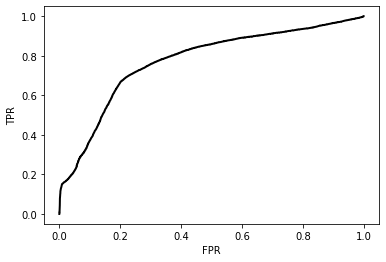

In [ ]:
acc, rec, pre, roc = print_result(X_test, y_test)

accl.append(acc)
recl.append(rec)
prel.append(pre)
rocl.append(roc)

50% 1:1

In [ ]:
negative_len_50 =  int(negative_len/2)


X_test = list(zip(positive_path[positive_len -  (negative_len_50) : positive_len] + negative_path[:negative_len_50], 
                positive_syscall[positive_len - (negative_len_50) : positive_len] + negative_syscall[:negative_len_50]))
y_test = [ 0 for i in range(negative_len_50)] + [ 1 for i in range(negative_len_50)]

accuracy score : 0.660848305662952
recall score : 0.4455310438935638
precision score : 0.7825044937088077
roc_auc : 0.7803171668569484


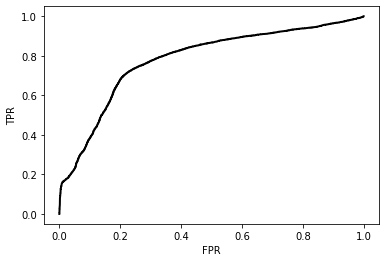

In [ ]:
acc, rec, pre, roc = print_result(X_test, y_test)

accl.append(acc)
recl.append(rec)
prel.append(pre)
rocl.append(roc)

25% 2:1

In [ ]:
negative_len_25 =  int(negative_len/4)


X_test = list(zip(positive_path[positive_len -  (2 * negative_len_25) : positive_len] + negative_path[:negative_len_25], 
                positive_syscall[positive_len - (2 * negative_len_75) : positive_len] + negative_syscall[:negative_len_25]))
y_test = [ 0 for i in range(2 * negative_len_25)] + [ 1 for i in range(negative_len_25)]

accuracy score : 0.6881206883481161
recall score : 0.33272685922219697
precision score : 0.5535376466136965
roc_auc : 0.6965235125009512


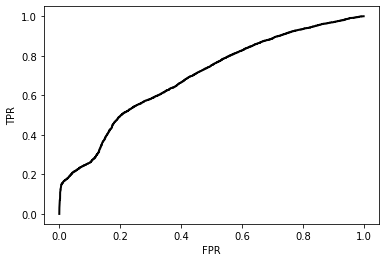

In [ ]:
acc, rec, pre, roc = print_result(X_test, y_test)

accl.append(acc)
recl.append(rec)
prel.append(pre)
rocl.append(roc)

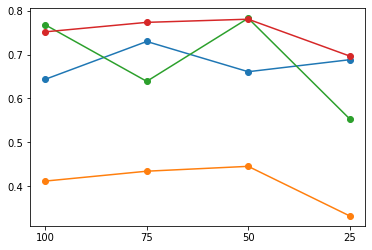

In [ ]:

percent = ['100', '75', '50', '25']

plt.plot(percent, accl, marker='o', label='A')
plt.plot(percent, recl, marker='o', label='R')
plt.plot(percent, prel, marker='o', label='P')
plt.plot(percent, rocl, marker='o', label='roc')
plt.show()

